In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

#### MC estimator for sparse graph

In [3]:
rng = Random.default_rng();

# graph parameters
n = 100
p = 0.05
eta = 0.3

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# percentage of label known
percent_labels = 0.5

# graph model
type = "ERO" 

n_batch = 200

nb_rep = 10

perf_mtsf = zeros(n_batch,nb_rep)
tau_full = zeros(nb_rep, 1)
tau_sync = zeros(nb_rep, 1)
tau_rand = zeros(nb_rep, 1)

for n_r = 1:nb_rep

    connected = false
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)

    while !connected
        if type=="MUN"
            meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
        elseif type=="ERO"
            meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
        end
        if length(connected_components(meta_g)) == 1
            connected = true
        end
    end

    B = magnetic_incidence(meta_g)
    L = B * B'

    ## define the labelled nodes
    y = zeros(ComplexF64,n, 1)

    # number of label
    batch = Int(ceil(percent_labels*n))
    
    # uniform sampling of labels
    id = rand(rng, 1:n, batch)
    y[id] = exp.(im * planted_score[id] * π / (n - 1));

    # baseline: exact score on id and random elsewhere
    score_rand = zeros(n, 1)
    score_rand[id] = planted_score[id]
    id_remaining = setdiff(1:n,id)
    n_remaining = length(id_remaining)
    score_remaining = planted_score[id_remaining]
    randomized_score = score_remaining[randperm(n_remaining)]
    score_rand[id_remaining] = randomized_score


    # linear system solution
    q = 10
    H_target = q*inv(L + q * I);

    
    x = zeros(ComplexF64,n,1)
    tau = zeros(n_batch,1)
    err = zeros(n_batch,1)
    pc_nodes_in_trees = zeros(n_batch,1)

    x_target = H_target * y

    H = zeros(ComplexF64,n,n)
    for l in 1:n_batch
        mtsf = multi_type_spanning_forest(rng, meta_g, q; weighted=true)
        vectors,pc_nodes = cumulate_angles(mtsf)
        for v in vectors
            scalar = v' * y
            x += v * scalar[1]
        end
        err[l] = norm(x/l - x_target)/norm(x_target)
        score = angular_score(x)
        ranking = ranking_from_score(score)
        tau[l] = corkendall(ranking,planted_ranking)
        pc_nodes_in_trees[l] = pc_nodes
    end

    x_full = q*inv(L + q * I)*y
    score = angular_score(x_full)
    ranking_full = ranking_from_score(score)
    tau_full[n_r] = corkendall(ranking_full,planted_ranking)

    singular = true
    ranking_sync = syncrank(L, meta_g; singular)
    tau_sync[n_r] = corkendall(planted_ranking, ranking_sync)

    ranking_rand = ranking_from_score(score_rand)
    tau_rand[n_r] = corkendall(planted_ranking, ranking_rand)

    perf_mtsf[:,n_r] = tau

end

## Plotting

m_full = mean(tau_full)
m_sync = mean(tau_sync)
m_rand = mean(tau_rand)


m_MC = zeros(n_batch,1)
std_MC = zeros(n_batch,1)
for i = 1:n_batch
    m_MC[i] = mean(perf_mtsf[i,:])
    std_MC[i] = std(perf_mtsf[i,:])
end

std_full = std(tau_full) * ones(n_batch,1)
std_sync = std(tau_sync) * ones(n_batch,1)
std_rand = std(tau_rand) * ones(n_batch,1)

scale = 1

plot(1:n_batch,m_MC,
ribbon=scale*std_MC,
fillalpha=.4,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "MC",
legend=:bottomright)

plot!(1:n_batch,m_full*ones(n_batch,1),
ribbon=scale*std_full,
fillalpha=.2,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "full",
legend=:bottomright)

plot!(1:n_batch,m_sync*ones(n_batch,1),
ribbon=scale*std_sync,
fillalpha=.2,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "sync-rank",
legend=:bottomright)

plot!(1:n_batch,m_rand*ones(n_batch,1),
ribbon=scale*std_rand,
fillalpha=.2,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "random",
legend=:bottomright)

xlabel!("number of MTSFs")
ylabel!("Kendall's tau distance ")

foldername = "figures/"
type = "MC"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)*".pdf"
savefig(foldername*name)

In [4]:
rng = Random.default_rng();

# graph parameters
n = 100
eta_range = 0:0.01:0.4
sparsity_range = 0.03:0.01:0.2

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# percentage of label known
percent_labels = 0.5

# graph model
type = "ERO" 

# parameter
q = 10

# initialization
n_noise = length(eta_range)
n_sparsity = length(sparsity_range)

semi = zeros(n_noise,n_sparsity)
sync = zeros(n_noise,n_sparsity)


n_rep = 20

for i in 1:n_noise
    eta = eta_range[i]
    for j in 1:n_sparsity
        p = sparsity_range[j]
        tau_sync = 0
        tau_semi = 0
        for _ in 1:n_rep
            connected = false
            meta_g = gen_graph_mun(rng, n, p, eta;planted_score)

            while !connected
                if type=="MUN"
                    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
                elseif type=="ERO"
                    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
                end
                if length(connected_components(meta_g)) == 1
                    connected = true
                end
            end

            B = magnetic_incidence(meta_g)
            L = B * B'

            ## define the labelled nodes
            y = zeros(ComplexF64,n, 1)

            # number of label
            batch = Int(ceil(percent_labels*n))

            # uniform sampling of labels
            id = rand(rng, 1:n, batch)
            y[id] = exp.(im * planted_score[id] * π / (n - 1));

            x_semi = q*inv(L + q * I)*y
            score = angular_score(x_semi)
            ranking_semi = ranking_from_score(score)
            tau_semi += corkendall(ranking_semi,planted_ranking)
        
            singular = true
            ranking_sync = syncrank(L, meta_g; singular)
            tau_sync += corkendall(planted_ranking, ranking_sync)
        end
        semi[i,j] = tau_semi/n_rep
        sync[i,j] =  tau_sync/n_rep
    end
end


table = semi ./ sync
heatmap(sparsity_range,eta_range,table,
xlabel = "edge probability",
ylabel="noise level",
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm)

foldername = "figures/"
type = "PhaseTransitionSemiSup"
name = type*"n"*string(n)*"p"*string(p)*"q"*string(q)*".pdf"
savefig(foldername*name)

In [8]:
heatmap(sparsity_range,eta_range,table,
xlabel = "edge probability",
ylabel="noise level",
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.16*2Plots.cm)

foldername = "figures/"
type = "PhaseTransitionSemiSup"
name = type*"n"*string(n)*"p"*string(p)*"q"*string(q)*".pdf"
savefig(foldername*name)

#### Old things

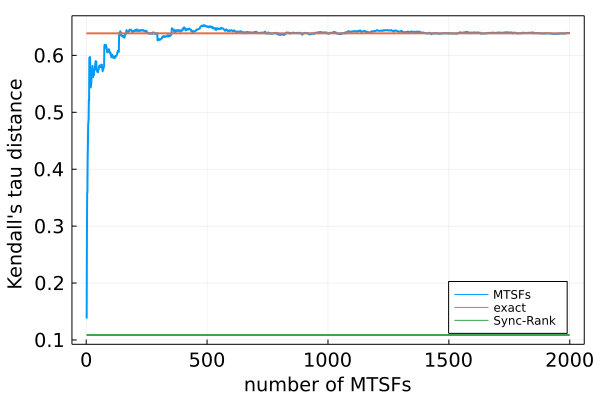

In [37]:
rng = Random.default_rng();

# graph parameters
n = 100
#p = 0.05
p = 0.05
eta = 0.3

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# percentage of label known
percent_labels = 0.5

# graph model
type = "ERO" 

connected = false
meta_g = gen_graph_mun(rng, n, p, eta;planted_score)

while !connected
    if type=="MUN"
        meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
    elseif type=="ERO"
        meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
    end
    if length(connected_components(meta_g)) == 1
        connected = true
    end
end

B = magnetic_incidence(meta_g)
L = B * B'

## define the labelled nodes
y = zeros(ComplexF64,n, 1)

# number of label
batch = Int(ceil(percent_labels*n))
# uniform sampling of labels
id = rand(rng, 1:n, batch)
y[id] = exp.(im * planted_score[id] * π / (n - 1));

# linear system solution
q = 10
H_target = q*inv(L + q * I);

# MC runs
n_batch = 2000

x = zeros(ComplexF64,n,1)
tau = zeros(n_batch,1)
err = zeros(n_batch,1)
pc_nodes_in_trees = zeros(n_batch,1)

x_target = H_target * y

H = zeros(ComplexF64,n,n)
for l in 1:n_batch
    mtsf = multi_type_spanning_forest(rng, meta_g, q; weighted=true)
    vectors,pc_nodes = cumulate_angles(mtsf)
    for v in vectors
        scalar = v' * y
        x += v * scalar[1]
    end
    err[l] = norm(x/l - x_target)/norm(x_target)
    score = angular_score(x)
    ranking = ranking_from_score(score)
    tau[l] = corkendall(ranking,planted_ranking)
    pc_nodes_in_trees[l] = pc_nodes
end

x_full = q*inv(L + q * I)*y
score = angular_score(x_full)
ranking_full = ranking_from_score(score)
tau_full = corkendall(ranking_full,planted_ranking)

singular = true
ranking_sync = syncrank(L, meta_g; singular)
tau_sync = corkendall(planted_ranking, ranking_sync)

## plotting

plot(1:n_batch,tau,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13), 
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "MTSFs")

plot!(1:n_batch,tau_full*ones(n_batch,1),
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13), 
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "exact")

plot!(1:n_batch,tau_sync*ones(n_batch,1),
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "Sync-Rank",
legend=:bottomright)

xlabel!("number of MTSFs")
ylabel!("Kendall's tau distance ")

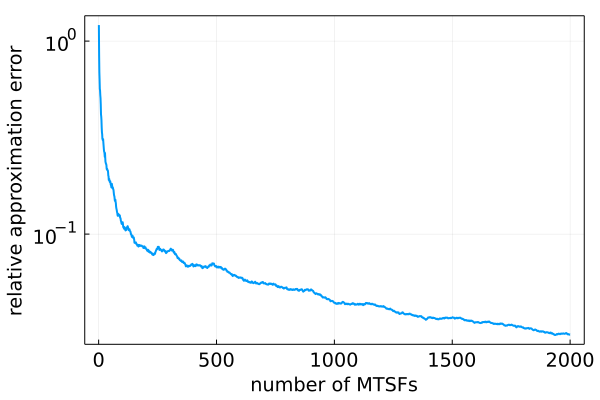

In [373]:
plot(1:n_batch,err,
linewidth=2,
yaxis=:log,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13), 
legendfont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
legend = false)
ylabel!("relative approximation error")
xlabel!("number of MTSFs")


In [393]:
rng = Random.default_rng();

# graph parameters
n = 100
p = 0.05
eta = 0.4

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# percentage of label known
percent_labels = 0.5

n_batch = 50

tau_semi = zeros(n_batch,1)
tau_sync = zeros(n_batch,1)

meta_g = gen_graph_mun(rng, n, p, eta;planted_score)

for i = 1:n_batch
    # graph model
    type = "ERO" 

    connected = false

    while !connected
        if type=="MUN"
            meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
        elseif type=="ERO"
            meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
        end
        if length(connected_components(meta_g)) == 1
            connected = true
        end
    end

    B = magnetic_incidence(meta_g)
    L = B * B'

    ## define the labelled nodes
    y = zeros(ComplexF64,n, 1)

    # number of label
    batch = Int(ceil(percent_labels*n))
    # uniform sampling of labels
    id = rand(rng, 1:n, batch)
    y[id] = exp.(im * planted_score[id] * π / (n - 1));

    # linear system solution
    q = 1

    x_full = q*inv(L + q * I)*y
    score = angular_score(x_full)
    ranking = ranking_from_score(score)
    tau_semi[i] = corkendall(ranking,planted_ranking)

    singular = true
    ranking_sync = syncrank(L, meta_g; singular)
    tau_sync[i] = corkendall(planted_ranking, ranking_sync)
end


println("tau_semi ", mean(tau_semi), " pm ", std(tau_semi))
println("tau_sync ", mean(tau_sync), " pm ", std(tau_sync))



tau_semi 0.5889535353535353 pm 0.07928545332643801
tau_sync 0.3657535353535353 pm 0.15546262013249923


In [36]:
rng = Random.default_rng();

# graph parameters
n = 100
#p = 0.05
p = 0.05
eta = 0.3

# planted ranking
planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

# percentage of label known
percent_labels = 0.5

# graph model
type = "ERO" 

n_batch = 200

nb_rep = 10

perf_mtsf = zeros(n_batch,nb_rep)
tau_full = zeros(nb_rep, 1)
tau_sync = zeros(nb_rep, 1)

for n_r = 1:nb_rep

    connected = false
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)

    while !connected
        if type=="MUN"
            meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
        elseif type=="ERO"
            meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
        end
        if length(connected_components(meta_g)) == 1
            connected = true
        end
    end

    B = magnetic_incidence(meta_g)
    L = B * B'

    ## define the labelled nodes
    y = zeros(ComplexF64,n, 1)

    # number of label
    batch = Int(ceil(percent_labels*n))
    # uniform sampling of labels
    id = rand(rng, 1:n, batch)
    y[id] = exp.(im * planted_score[id] * π / (n - 1));

    # linear system solution
    q = 10
    H_target = q*inv(L + q * I);

    
    x = zeros(ComplexF64,n,1)
    tau = zeros(n_batch,1)
    err = zeros(n_batch,1)
    pc_nodes_in_trees = zeros(n_batch,1)

    x_target = H_target * y

    H = zeros(ComplexF64,n,n)
    for l in 1:n_batch
        mtsf = multi_type_spanning_forest(rng, meta_g, q; weighted=true)
        vectors,pc_nodes = cumulate_angles(mtsf)
        for v in vectors
            scalar = v' * y
            x += v * scalar[1]
        end
        err[l] = norm(x/l - x_target)/norm(x_target)
        score = angular_score(x)
        ranking = ranking_from_score(score)
        tau[l] = corkendall(ranking,planted_ranking)
        pc_nodes_in_trees[l] = pc_nodes
    end

    x_full = q*inv(L + q * I)*y
    score = angular_score(x_full)
    ranking_full = ranking_from_score(score)
    tau_full[n_r] = corkendall(ranking_full,planted_ranking)

    singular = true
    ranking_sync = syncrank(L, meta_g; singular)
    tau_sync[n_r] = corkendall(planted_ranking, ranking_sync)

    perf_mtsf[:,n_r] = tau

end



m_full = mean(tau_full)
m_sync = mean(tau_sync)


m_MC = zeros(n_batch,1)
std_MC = zeros(n_batch,1)

for i = 1:n_batch
    m_MC[i] = mean(perf_mtsf[i,:])
    std_MC[i] = std(perf_mtsf[i,:])
end

std_full = std(tau_full) * ones(n_batch,1)
std_sync = std(tau_sync) * ones(n_batch,1)

scale = 1

plot(1:n_batch,m_MC,
ribbon=scale*std_MC,
fillalpha=.4,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "MC",
legend=:bottomright)

plot!(1:n_batch,m_full*ones(n_batch,1),
ribbon=scale*std_full,
fillalpha=.2,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "full",
legend=:bottomright)

plot!(1:n_batch,m_sync*ones(n_batch,1),
ribbon=scale*std_sync,
fillalpha=.2,
linewidth=2,
xtickfont=font(13), 
ytickfont=font(13), 
guidefont=font(13),
framestyle = :box,
margins = 0.1*2Plots.cm,
labels = "sync-rank",
legend=:bottomright)

xlabel!("number of MTSFs")
ylabel!("Kendall's tau distance ")